In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing

### Custom Data Converters

The data within the csv files have certain prefixes such as dollar signs that we don't want included in the pandas dataframe. Thus, when reading from specific columns, we can tell pandas to follow a pipeline that converts the cell data into data within a desirable form.

In [2]:
# Removes the dollar signs and commas
def custom_dollar_converter(dollar_str):
    if '#' in dollar_str:
        return np.nan
    else:
        dollar_str = dollar_str.replace('$', '').replace(',', '')
        return float(dollar_str)

In [3]:
# Determines whether a business is a franchise or not
# If the value is 0 or 1, the business is not a franchise
def custom_franchise_converter(franchise_str):
    if franchise_str.strip() == '0' or franchise_str.strip() == '1':
        return 0
    else:
        return 1

In [4]:
# Trims zip codes to the first two numbers
def zip_trimmer(zip_str):
    return zip_str[:2]

The `NAICS` is a code used by the US government to identify individual industries. This is useful to see if certain industries get loans more often. The first 2 digits of the NAICS code can give information about the type of business.

| Sector | Description |
| --- | --- |
| 11 | Agriculture, forestry, fishing and hunting |
| 21 | Mining, quarrying, and oil and gas extraction |
| 22 | Utilities |
| 23 | Construction |
| 31–33 | Manufacturing |
| 42 | Wholesale trade |
| 44–45 | Retail trade |
| 48–49 | Transportation and warehousing |
| 51 | Information |
| 52 | Finance and insurance |
| 53 | Real estate and rental and leasing |
| 54 | Professional, scientific, and technical services |
| 55 | Management of companies and enterprises |
| 56 | Administrative and support and waste management and remediation services |
| 61 | Educational services |
| 62 | Health care and social assistance |
| 71 | Arts, entertainment, and recreation |
| 72 | Accommodation and food services |
| 81 | Other services (except public administration) 92 Public administration |

In [5]:
# Returns the first two digits of a NAICS value
def naics_trimmer(naics_str):
    return naics_str[:2]

### Reading in Data

The specific converters deifned above can be listed in a dictionary, with the columns matched to their specific converter. Pandas will account these when reading data. Additionally, the csv file contains datetime information; we can specify which columns contain datetime information for pandas to automatically read them in as datetime information.

In [6]:
bank_converters = {
    'DisbursementGross': custom_dollar_converter,
    'BalanceGross': custom_dollar_converter,
    'ChgOffPrinGr': custom_dollar_converter,
    'GrAppv': custom_dollar_converter,
    'SBA_Appv': custom_dollar_converter,
    'FranchiseCode': custom_franchise_converter,
    'Zip': zip_trimmer,
#     'NAICS': naics_trimmer, # not using b/c so many samples have null value
}

bank_parse_dates = [ 'ApprovalDate', 'ChgOffDate', 'DisbursementDate' ]

df = pd.read_csv(
    'SBAnational.csv',
    converters=bank_converters,
    parse_dates=bank_parse_dates,
    date_parser=pd.to_datetime,
)
df.head()

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47,FIFTH THIRD BANK,OH,451120,1997-02-28,1997,...,N,Y,NaT,1999-02-28,60000.0,0.0,P I F,0.0,60000.0,48000.0
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46,1ST SOURCE BANK,IN,722410,1997-02-28,1997,...,N,Y,NaT,1997-05-31,40000.0,0.0,P I F,0.0,40000.0,32000.0
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47,GRANT COUNTY STATE BANK,IN,621210,1997-02-28,1997,...,N,N,NaT,1997-12-31,287000.0,0.0,P I F,0.0,287000.0,215250.0
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74,1ST NATL BK & TR CO OF BROKEN,OK,0,1997-02-28,1997,...,N,Y,NaT,1997-06-30,35000.0,0.0,P I F,0.0,35000.0,28000.0
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32,FLORIDA BUS. DEVEL CORP,FL,0,1997-02-28,1997,...,N,N,NaT,1997-05-14,229000.0,0.0,P I F,0.0,229000.0,229000.0


In [7]:
df.shape

(899164, 27)

The dataframe contains `27` columns, or **features**, and `899164` rows, or **samples**. The features that the dataset contains are listed below.

In [8]:
print(df.columns)

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv'],
      dtype='object')


### Handling Null Values

Null values pose a problem because if they were passed in to the machine learning model, it wouldn't have enough information to go off of and would produce many inconsistencies. Since the dataframe has a huge amount of samples, it wouldn't hurt to just remove the columns with any null values.

In [9]:
df.isna().any().loc[df.isna().any()]  # outputs all columns with null values

Name                True
City                True
State               True
Bank                True
BankState           True
NewExist            True
RevLineCr           True
LowDoc              True
ChgOffDate          True
DisbursementDate    True
MIS_Status          True
dtype: bool

Before deleting the samples with null values in any row, we can figure out which columns are unimportant and therefore can be dropped.
The columns that are unimportant from the ones that have null values are:
* `Name`
* `ChgOffDate`
* `DisbursementDate` *(subject to change)*


The columns that are unimportant even though they don't have null values are:
* `LoanNr_ChkDgt`
* `City` *(subject to change)*
* `Bank`
* `NAICS` *(subject to change)*
* `CreateJob` *(subject to change)*
* `RetainedJob` *(subject to change)*
* `ChgOffPrinGr`
* `RevLineCr` *(data was bad)*
* `LowDoc` *(didn't include `RevLineCr`)*

In [10]:
# This cell removes the unwanted columns described above

drop_columns = [
    'Name', 'City', 'ChgOffDate', 'DisbursementDate',
    'LoanNr_ChkDgt', 'Bank', 'NAICS',
    'CreateJob', 'RetainedJob', 'ChgOffPrinGr',
    'RevLineCr', 'LowDoc',
]
working_df = df.drop(columns=drop_columns)

In [11]:
# makes the NewExist variable more intuitive
# a value of 1 means the business is new
# a value of 0 means the business is not new
working_df['NewExist'] = working_df['NewExist'].replace({ 2:1, 1:0 })

In [12]:
working_df.shape

(899164, 15)

With the unwanted columns removed, it is now possible to remove any sample with any null values included, while still retaining the largest number of samples possible.

In [13]:
cols = list(working_df.columns)

for col in cols:
    rows_to_remove = []
    nulled_col = list(working_df[col].isnull())
    for i in range(len(nulled_col)):
        if nulled_col[i] == True:
            rows_to_remove.append(i)
    rows_to_remove.sort(reverse=True)

    working_df = working_df.drop(rows_to_remove)
    working_df = working_df.reset_index(drop=True)

    print('Removed null values from:', col)

Removed null values from: State
Removed null values from: Zip
Removed null values from: BankState
Removed null values from: ApprovalDate
Removed null values from: ApprovalFY
Removed null values from: Term
Removed null values from: NoEmp
Removed null values from: NewExist
Removed null values from: FranchiseCode
Removed null values from: UrbanRural
Removed null values from: DisbursementGross
Removed null values from: BalanceGross
Removed null values from: MIS_Status
Removed null values from: GrAppv
Removed null values from: SBA_Appv


In [14]:
working_df.shape

(895507, 15)

With no more null values remaining in the dataset, we still retain a large number of samples. The dataset is now trimmed to `895507` samples and `15` features, which is more than enough data.

### Prepping Data for Training

Categorical variables, or variables that don't depend on a numerical value, can be label encoded such that all the different types of entries possible correspond to a numerical value.

In [15]:
from sklearn.preprocessing import LabelEncoder

The **MIS_Status** column has two values: `PIF` or `CHGOFF`, and label encoding can make each correspond to either a `0` or a `1`.

In [16]:
mis_label_encoder = LabelEncoder()
mis_encoded = mis_label_encoder.fit_transform(working_df['MIS_Status'])
mis_encoded

array([1, 1, 1, ..., 1, 0, 1])

In [17]:
mis_label_encoder.inverse_transform(mis_encoded)

array(['P I F', 'P I F', 'P I F', ..., 'P I F', 'CHGOFF', 'P I F'],
      dtype=object)

In [18]:
working_df['MIS_Status'] = mis_encoded

In [19]:
working_df.head()

,State,Zip,BankState,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,FranchiseCode,UrbanRural,DisbursementGross,BalanceGross,MIS_Status,GrAppv,SBA_Appv
0,IN,47,OH,1997-02-28,1997,84,4,1.0,0,0,60000.0,0.0,1,60000.0,48000.0
1,IN,46,IN,1997-02-28,1997,60,2,1.0,0,0,40000.0,0.0,1,40000.0,32000.0
2,IN,47,IN,1997-02-28,1997,180,7,0.0,0,0,287000.0,0.0,1,287000.0,215250.0
3,OK,74,OK,1997-02-28,1997,60,2,0.0,0,0,35000.0,0.0,1,35000.0,28000.0
4,FL,32,FL,1997-02-28,1997,240,14,0.0,0,0,229000.0,0.0,1,229000.0,229000.0


The **NewExist** column can be **one-hot encoded**. This means that out of the NewExist column, we get two columns, each containing binary information of `True` or `False`. For the **NewExistTrue** column, it will contain the value of `True` when a business is new and a value of `False` when it isn't. The **NewExistFalse** column is essentially the inverse.

In [20]:
new_exist_true = working_df['NewExist'] == 1
new_exist_false = working_df['NewExist'] == 0

In [21]:
working_df['NewExistTrue'] = new_exist_true
working_df['NewExistFalse'] = new_exist_false
working_df = working_df.drop(columns=['NewExist'])
working_df.head()

,State,Zip,BankState,ApprovalDate,ApprovalFY,Term,NoEmp,FranchiseCode,UrbanRural,DisbursementGross,BalanceGross,MIS_Status,GrAppv,SBA_Appv,NewExistTrue,NewExistFalse
0,IN,47,OH,1997-02-28,1997,84,4,0,0,60000.0,0.0,1,60000.0,48000.0,True,False
1,IN,46,IN,1997-02-28,1997,60,2,0,0,40000.0,0.0,1,40000.0,32000.0,True,False
2,IN,47,IN,1997-02-28,1997,180,7,0,0,287000.0,0.0,1,287000.0,215250.0,False,True
3,OK,74,OK,1997-02-28,1997,60,2,0,0,35000.0,0.0,1,35000.0,28000.0,False,True
4,FL,32,FL,1997-02-28,1997,240,14,0,0,229000.0,0.0,1,229000.0,229000.0,False,True


We can separate the date information within **ApprovalData** into separate columns, one for the month, one for the year, and one for the day.

In [22]:
approval_date_months = working_df['ApprovalDate'].dt.month
approval_date_days = working_df['ApprovalDate'].dt.day

In [23]:
working_df['ApprovalMonth'] = approval_date_months
working_df['ApprovalDay'] = approval_date_days
working_df = working_df.drop(columns=['ApprovalDate'])

The following piece of code is a fix for a problem within the dataset. One of the entries for the year is `1976A` instead of `1976`. This just fixes that.

In [24]:
approval_years = []
for date in working_df['ApprovalFY']:
    if date == '1976A':
        approval_years.append(1976)
    else:
        approval_years.append(int(date))

working_df['ApprovalFY'] = np.array(approval_years).astype(np.int64)

Since the **State** and **BankState** column both have textual information that have 51 possibilities, they have to be encoded in a numerical value and this is the perfect use case for label encoding. It maps each of the 51 states/territories to a specific number.

In [25]:
len(working_df.State.unique())

51

In [26]:
state_label_encoder = LabelEncoder()
state_encoded = state_label_encoder.fit_transform(working_df['State'])
bank_state_encoded = state_label_encoder.fit_transform(working_df['BankState'])

In [27]:
working_df['State'] = state_encoded
working_df['BankState'] = bank_state_encoded

The **Zip** column contains numeric data in a string format. For the model to actually understand the data, it is imperative that the string format is converted to a numerical format.

In [28]:
working_df['Zip'] = pd.to_numeric(working_df['Zip'])

In [29]:
working_df

,State,Zip,BankState,ApprovalFY,Term,NoEmp,FranchiseCode,UrbanRural,DisbursementGross,BalanceGross,MIS_Status,GrAppv,SBA_Appv,NewExistTrue,NewExistFalse,ApprovalMonth,ApprovalDay
0,15,47,38,1997,84,4,0,0,60000.0,0.0,1,60000.0,48000.0,True,False,2,28
1,15,46,18,1997,60,2,0,0,40000.0,0.0,1,40000.0,32000.0,True,False,2,28
2,15,47,18,1997,180,7,0,0,287000.0,0.0,1,287000.0,215250.0,False,True,2,28
3,36,74,39,1997,60,2,0,0,35000.0,0.0,1,35000.0,28000.0,False,True,2,28
4,9,32,11,1997,240,14,0,0,229000.0,0.0,1,229000.0,229000.0,False,True,2,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895502,35,43,17,1997,60,6,0,0,70000.0,0.0,1,70000.0,56000.0,False,True,2,27
895503,35,43,17,1997,60,6,0,0,85000.0,0.0,1,85000.0,42500.0,False,True,2,27
895504,4,93,5,1997,108,26,0,0,300000.0,0.0,1,300000.0,225000.0,False,True,2,27
895505,11,96,14,1997,60,6,0,0,75000.0,0.0,0,75000.0,60000.0,False,True,2,27


The final version of the dataset with all the tweaks is shown above. It accounts for null values, string data label encoded.

### Data Split

In order to train the machine learning model, it is important to have both training data and testing data, so that you know your model has not just memorized the training data. We can use the **sklearn** module's `train_test_split` function to create a split with ease.

In [30]:
from sklearn.model_selection import train_test_split

First we separate the training features and the target column into the variables `X` and `y`, respectively.

In [31]:
X = working_df.drop(columns=['MIS_Status'])
y = working_df['MIS_Status']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Converting the data to arrays makes the final models easier to use for predictions.
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Training Models

### Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
clf = RandomForestClassifier(n_estimators=100, verbose=2, n_jobs=-1, random_state=0)
clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100
building tree 4 of 100

building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100building tree 70 of 100

building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.8min finished


RandomForestClassifier(n_jobs=-1, random_state=0, verbose=2)

### XGBOOST

In [36]:
import xgboost as xgb

In [37]:
xgb_model = xgb.XGBClassifier(n_estimators=100, n_jobs=-1, random_state=0)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

# Testing Model Accuracy

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

### Random Forest

In [39]:
preds = clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.6s finished


In [40]:
clf.score(X_test, y_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.4s finished


0.9478509452714096

In [41]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84     31470
           1       0.96      0.98      0.97    147632

    accuracy                           0.95    179102
   macro avg       0.93      0.89      0.91    179102
weighted avg       0.95      0.95      0.95    179102



### XGBOOST

In [43]:
preds = xgb_model.predict(X_test)

In [44]:
xgb_model.score(X_test, y_test)

0.9516420810487879

In [45]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86     31470
           1       0.97      0.98      0.97    147632

    accuracy                           0.95    179102
   macro avg       0.92      0.91      0.92    179102
weighted avg       0.95      0.95      0.95    179102



# SHAP values

In [48]:
import shap

In [53]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=42)

### Random Forest

In [50]:
explainer = shap.Explainer(clf)

In [51]:
shap_values = explainer.shap_values(X_test[:50])

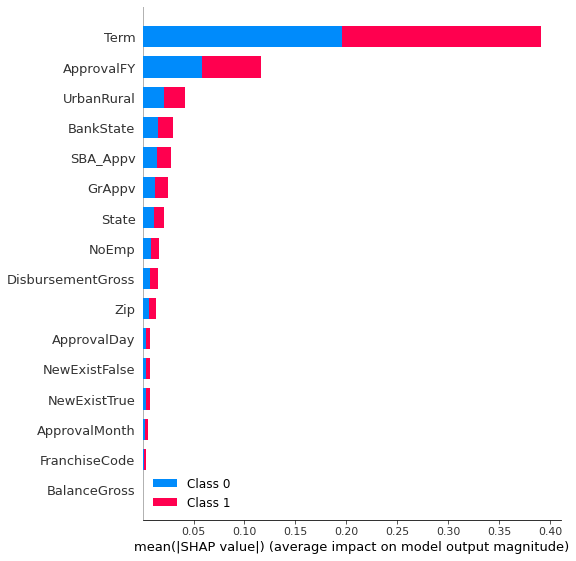

In [63]:
shap.summary_plot(
    shap_values,
    feature_names=X_train_1.columns,
)

### XGBOOST

In [64]:
explainer = shap.Explainer(xgb_model)

In [65]:
shap_values = explainer.shap_values(X_test[:50])

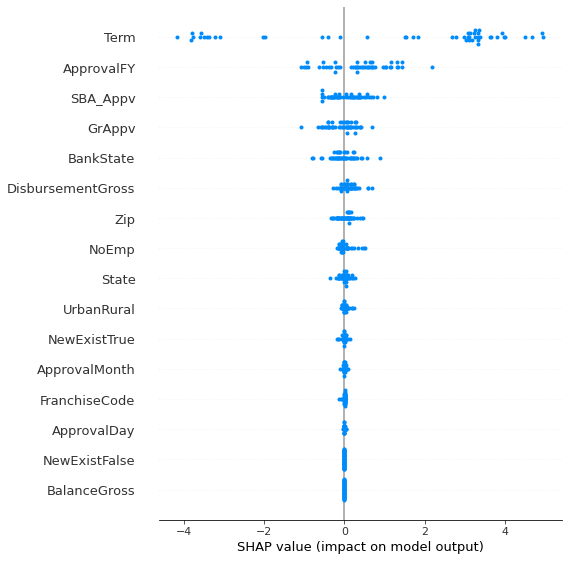

In [66]:
shap.summary_plot(
    shap_values,
    feature_names=X_train_1.columns,
)